In [1]:
from data_helper import get_dataloaders_and_standarscaler_photons
from train_helper import train_vae
from plot_helper import plot_training_loss

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import time
import seaborn as sns

# from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

In [2]:
# Hyperparameters
RANDOM_SEED = 123
# LEARNING_RATE = 0.0005
# BATCH_SIZE = 1024
NUM_EPOCHS = 5
LOGGING_INTERVAL=250
# RECONSTRUCTION_TERM_WEIGHT=2.8
SAVE_MODEL_FILE=None#'checkpoint.pth'
path='./DATA/photons.npy'

In [3]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [4]:
loaded_checkpoint = torch.load("checkpoint.pth")
epoch = loaded_checkpoint["epoch"]
print(epoch)
model_name=loaded_checkpoint["model_name"]
print(model_name)

30
VAE_Linear


In [5]:
model = getattr(__import__('models_architecture_helper', fromlist=[model_name]), model_name)

In [6]:
model=model()
model.to(DEVICE)
model.load_state_dict(loaded_checkpoint["model_state"])


optimizer = torch.optim.Adam(model.parameters(),
                             lr=0, 
                             weight_decay=1e-5)

optimizer.load_state_dict(loaded_checkpoint["optim_state"])
BATCH_SIZE = loaded_checkpoint["batch_size"]
RECONSTRUCTION_TERM_WEIGHT = loaded_checkpoint["reconstruction_term_weight"]
log_dict_old=loaded_checkpoint["log_dict"]

#print(optimizer.state_dict)

In [7]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros(photons.shape,dtype=np.float32)
np.copyto(X,photons)

In [8]:
df_data = pd.DataFrame(X, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane

,X,Y,dX,dY,dZ,E
0,0.42000,1.05666,-5.14814,0.040652,-0.198063,0.979346
1,0.26173,-1.74098,-4.74566,0.052218,-0.303938,0.951260
2,0.39096,1.24705,4.90818,0.019018,0.337769,0.941037
3,0.42000,2.54507,-3.28148,0.098677,-0.127226,0.986953
4,0.42000,1.33431,-4.38559,0.051587,-0.169556,0.984170


In [9]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons(path=path,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.2, 
    validation_fraction=0.0)

In [10]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train = data_train

print(features_train.shape)

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test = data_test


torch.Size([1024, 6])


In [11]:
# model = VAE_Linear()
# model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr=LEARNING_RATE, 
#                              weight_decay=1e-5)

In [12]:
log_dict_new=train_vae(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=LOGGING_INTERVAL, reconstruction_term_weight=RECONSTRUCTION_TERM_WEIGHT, save_model_file=SAVE_MODEL_FILE)



Epoch: 001/005 | Batch 0000/0777 | Loss: 5.0374
Epoch: 001/005 | Batch 0250/0777 | Loss: 4.7798
Epoch: 001/005 | Batch 0500/0777 | Loss: 4.6537
Epoch: 001/005 | Batch 0750/0777 | Loss: 4.9711
***Epoch: 001/005 | Loss: 2.021
Test***Epoch: 001/005 | Loss: 2.011
Time elapsed: 0.39 min
Epoch: 002/005 | Batch 0000/0777 | Loss: 4.7164
Epoch: 002/005 | Batch 0250/0777 | Loss: 5.1884
Epoch: 002/005 | Batch 0500/0777 | Loss: 4.9663
Epoch: 002/005 | Batch 0750/0777 | Loss: 4.9718
***Epoch: 002/005 | Loss: 2.013
Test***Epoch: 002/005 | Loss: 2.003
Time elapsed: 0.77 min
Epoch: 003/005 | Batch 0000/0777 | Loss: 4.9842
Epoch: 003/005 | Batch 0250/0777 | Loss: 4.8325
Epoch: 003/005 | Batch 0500/0777 | Loss: 4.8919
Epoch: 003/005 | Batch 0750/0777 | Loss: 4.8509
***Epoch: 003/005 | Loss: 2.019
Test***Epoch: 003/005 | Loss: 2.008
Time elapsed: 1.17 min
Epoch: 004/005 | Batch 0000/0777 | Loss: 5.1432
Epoch: 004/005 | Batch 0250/0777 | Loss: 4.8783
Epoch: 004/005 | Batch 0500/0777 | Loss: 4.7351
Epoch: 

In [13]:
log_dict={ key:log_dict_old.get(key,[])+log_dict_new.get(key,[]) for key in set(list(log_dict_old.keys())+list(log_dict_new.keys())) }

In [14]:
print(log_dict["test_combined_loss_per_epoch"])

[4.373135089874268, 3.132791757583618, 2.533102512359619, 2.392599105834961, 2.270780563354492, 2.2005603313446045, 2.1866049766540527, 2.1847920417785645, 2.1665406227111816, 2.1715035438537598, 2.154984474182129, 2.1367027759552, 2.140626907348633, 2.138139247894287, 2.1509907245635986, 2.1211013793945312, 2.0916523933410645, 2.1009700298309326, 2.0931026935577393, 2.084960460662842, 2.086298704147339, 2.0806987285614014, 2.083773612976074, 2.072045087814331, 2.059840679168701, 2.0559568405151367, 2.038992404937744, 2.027421474456787, 2.0265543460845947, 2.0319552421569824, 2.011173963546753, 2.0029096603393555, 2.008161783218384, 1.9907151460647583, 2.0006935596466064]


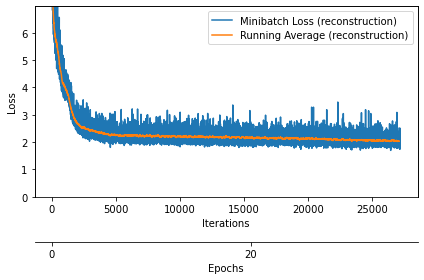

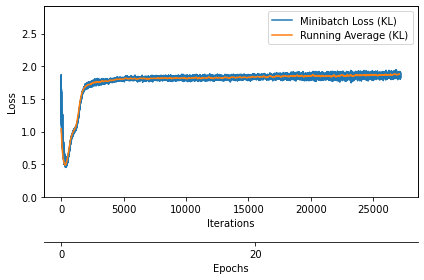

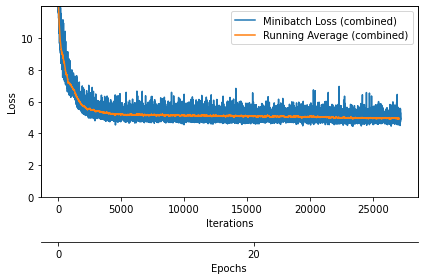

In [15]:
epoch_all=epoch+NUM_EPOCHS
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], epoch_all, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], epoch_all, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], epoch_all, custom_label=" (combined)")
plt.show()



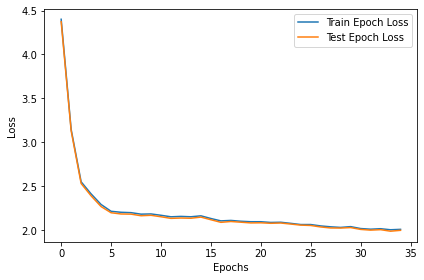

In [16]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [17]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
model.eval()
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

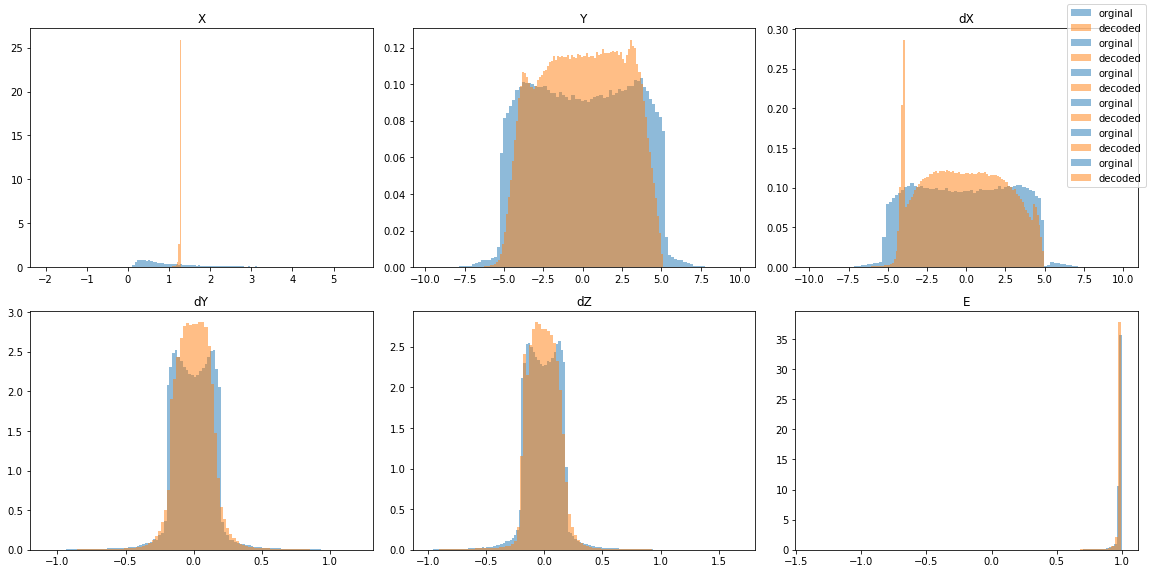

In [18]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 0].hist(result[:,0],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 1].hist(result[:,1],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 2].hist(result[:,2],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 0].hist(result[:,3],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 1].hist(result[:,4],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 2].hist(result[:,5],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 2].set_title('E')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

Index(['X', 'Y', 'dX', 'dY', 'dZ', 'E'], dtype='object')
[-1.99839079e+00 -1.97308417e+00 -1.94777754e+00 -1.92247092e+00
 -1.89716429e+00 -1.87185767e+00 -1.84655104e+00 -1.82124442e+00
 -1.79593779e+00 -1.77063116e+00 -1.74532454e+00 -1.72001791e+00
 -1.69471129e+00 -1.66940466e+00 -1.64409804e+00 -1.61879141e+00
 -1.59348479e+00 -1.56817816e+00 -1.54287153e+00 -1.51756491e+00
 -1.49225828e+00 -1.46695166e+00 -1.44164503e+00 -1.41633841e+00
 -1.39103178e+00 -1.36572516e+00 -1.34041853e+00 -1.31511191e+00
 -1.28980528e+00 -1.26449865e+00 -1.23919203e+00 -1.21388540e+00
 -1.18857878e+00 -1.16327215e+00 -1.13796553e+00 -1.11265890e+00
 -1.08735228e+00 -1.06204565e+00 -1.03673902e+00 -1.01143240e+00
 -9.86125773e-01 -9.60819148e-01 -9.35512522e-01 -9.10205897e-01
 -8.84899271e-01 -8.59592646e-01 -8.34286020e-01 -8.08979395e-01
 -7.83672769e-01 -7.58366144e-01 -7.33059518e-01 -7.07752893e-01
 -6.82446267e-01 -6.57139642e-01 -6.31833016e-01 -6.06526391e-01
 -5.81219765e-01 -5.55913140e-01 

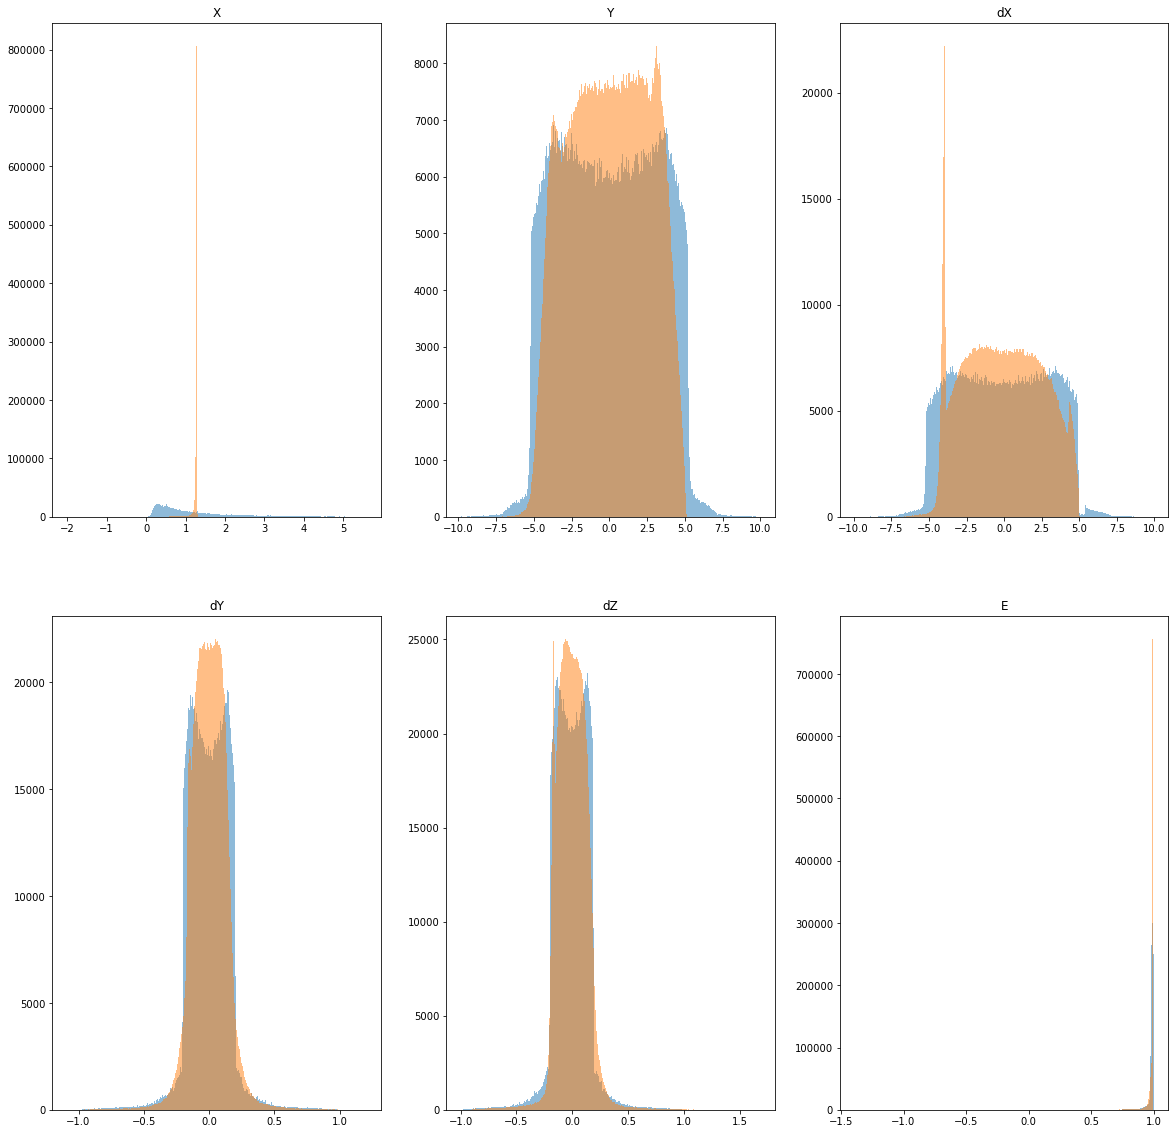

In [19]:
keys = df_data.columns
print(keys)
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 20)
for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    print(bins)
    axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5)
    axs.flatten()[i].hist(result[:, i], bins, alpha=.5)
    axs.flatten()[i].set_title(j)







In [20]:
decoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


In [21]:
# g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
# g.map_upper(sns.scatterplot)
# #g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

In [22]:
#sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)


In [23]:
#TODO trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=0.03, random_state=2)) 
print(sample.shape)
print(sample.head())

(59724, 7)
                X         Y        dX        dY        dZ         E  \
1174565  1.285707 -1.693698  1.182188 -0.067558  0.058806  0.988260   
1609424  1.268802  4.248696 -0.960164  0.171718 -0.043855  0.987152   
1539655  1.277695  1.799212  2.002639  0.071709  0.086753  0.988312   
1506954  1.275521  1.049296 -2.333959  0.043520 -0.096183  0.986943   
1855494  1.267619  3.976377 -2.928023  0.161045 -0.127181  0.986555   

        dataset_name  
1174565      decoded  
1609424      decoded  
1539655      decoded  
1506954      decoded  
1855494      decoded  


In [24]:
# sns.pairplot(sample, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [25]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
model.eval()
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [26]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [27]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.061480,0.760660,-2.516470,0.029714,-0.098330,0.994710
1,1.270151,2.718269,-3.405058,0.106698,-0.146231,0.986675


In [28]:
encoded_features=[]
model.eval()
for index, feature in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(feature.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(795648, 3)


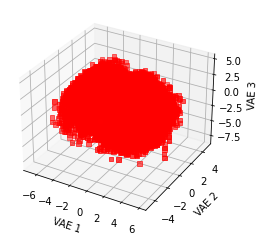

In [29]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,1],encoded_features[:,2],marker=m,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()